In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [31]:
trainfile = 'train.csv'
testfile = 'test.csv'
train = pd.read_csv(trainfile)
test = pd.read_csv(testfile)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [32]:
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f15c150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10f187950>]], dtype=object)

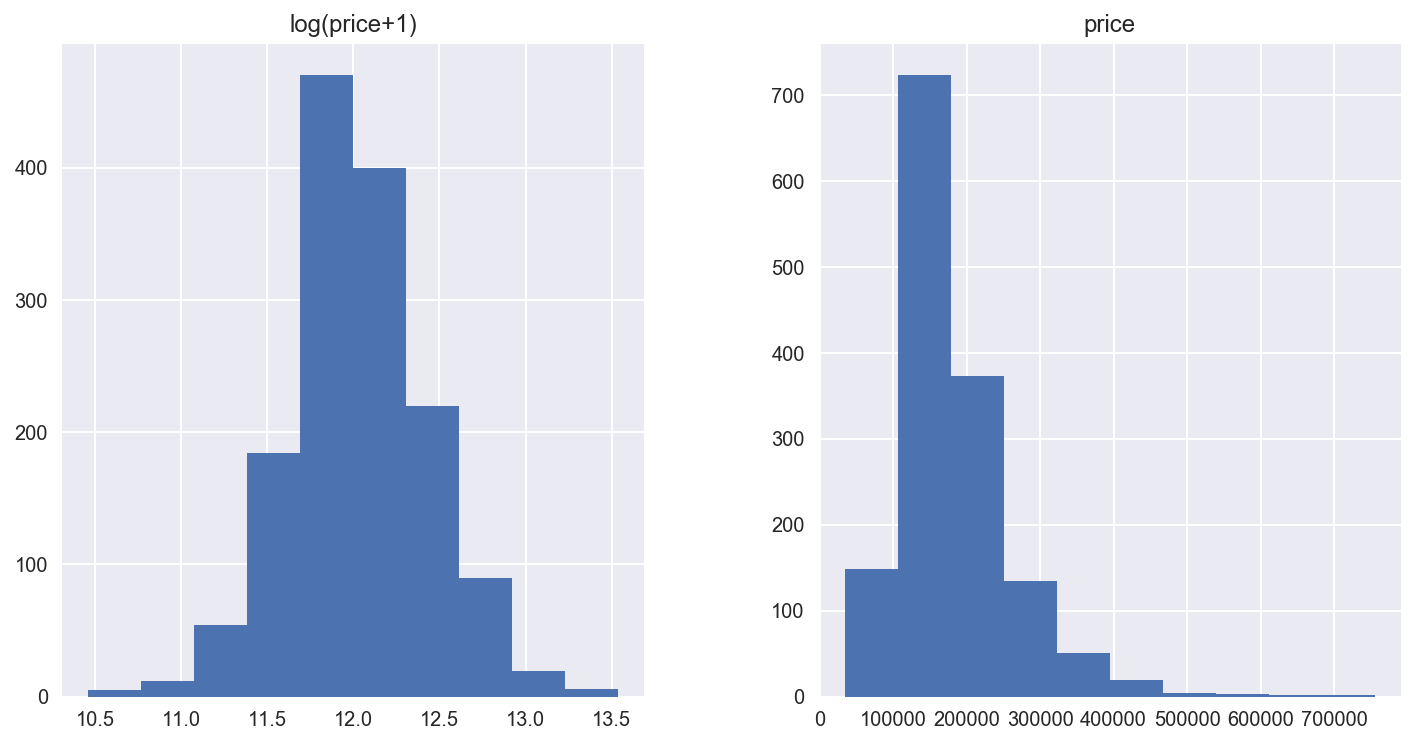

In [33]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({
    'price': train['SalePrice'],
    'log(price+1)': np.log1p(train['SalePrice'])
})
prices.hist()

In [34]:
#处理类型不为object且偏斜度过大的数据
train['SalePrice'] = np.log1p(train['SalePrice'])

numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
# skewed_feats

In [35]:
#生成哑变量矩阵
all_data = pd.get_dummies(all_data)

In [36]:
#使用平均值填补空缺值
all_data = all_data.fillna(all_data.mean())

In [37]:
#建立训练矩阵
x_train = all_data[:train.shape[0]]
x_test = all_data[train.shape[0]:]
y = train.SalePrice

In [38]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score


def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(
        model, x_train, y, scoring='neg_mean_squared_error', cv=5))
    return (rmse)

In [39]:
model_ridge = Ridge()

In [40]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

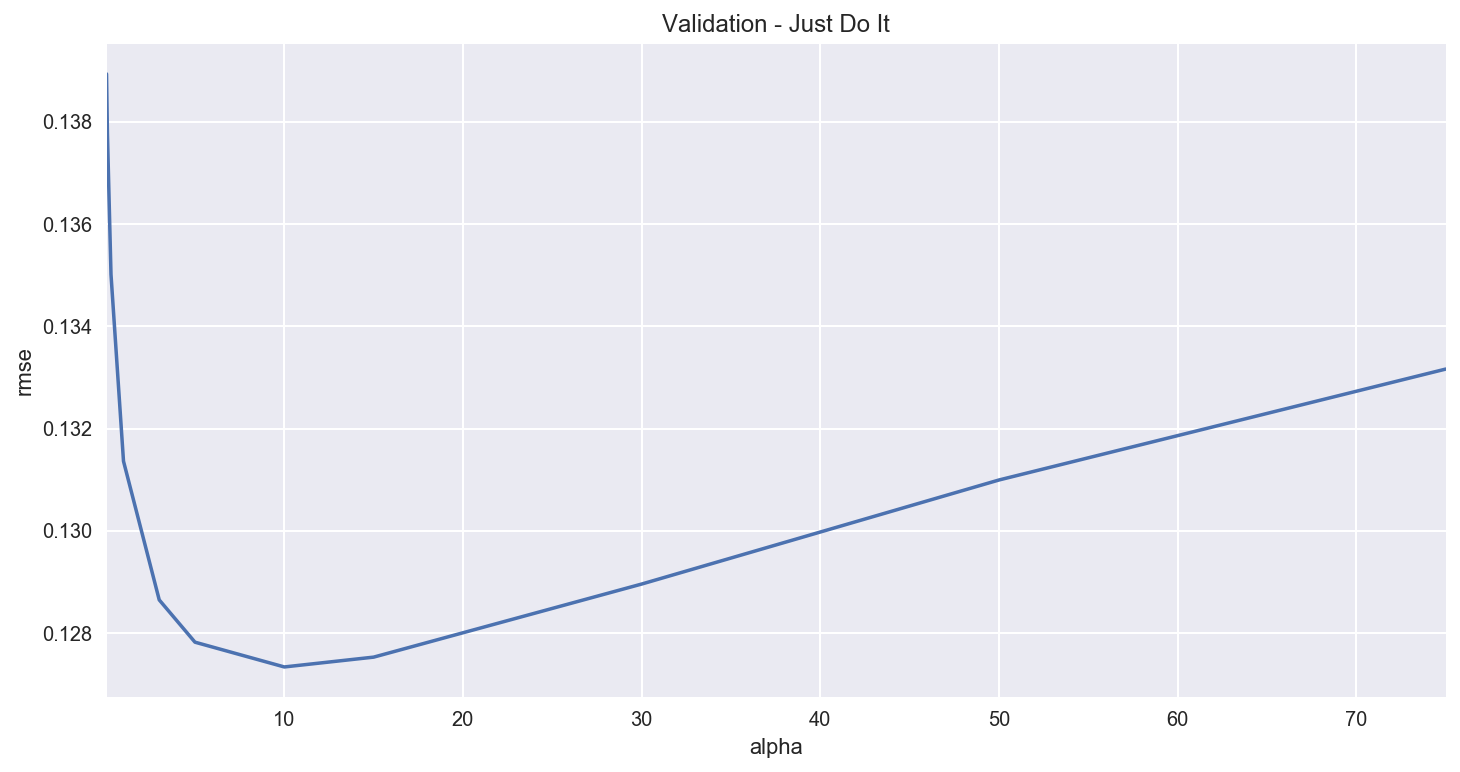

In [41]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Validation - Just Do It')
plt.xlabel('alpha')
plt.ylabel('rmse')

In [42]:
cv_ridge.min()

0.12733734668670763

In [43]:
model_lasso = LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(x_train, y)

In [44]:
rmse_cv(model_lasso).mean()

0.12314421090977448

In [45]:
coef = pd.Series(model_lasso.coef_, index=x_train.columns)
print("Lasso picked " + str(sum(coef != 0)) +
      " variables and eliminated the other " + str(sum(coef == 0)) +
      " variables")

Lasso picked 111 variables and eliminated the other 177 variables


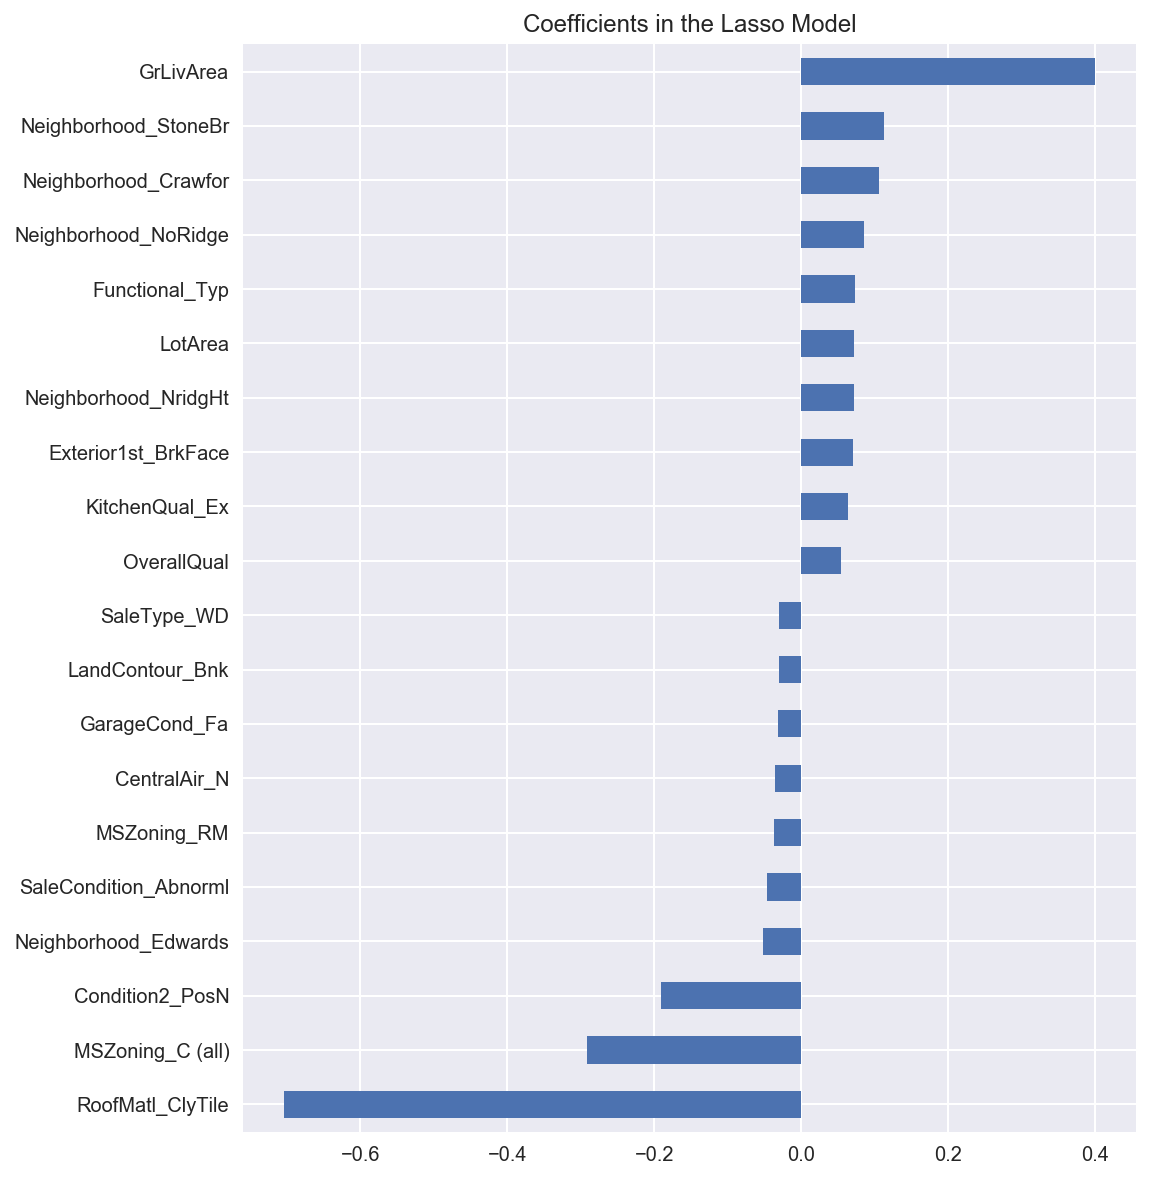

In [46]:
imp_coef = pd.concat(
    [coef.sort_values().head(10),
     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind="barh")
plt.title("Coefficients in the Lasso Model")

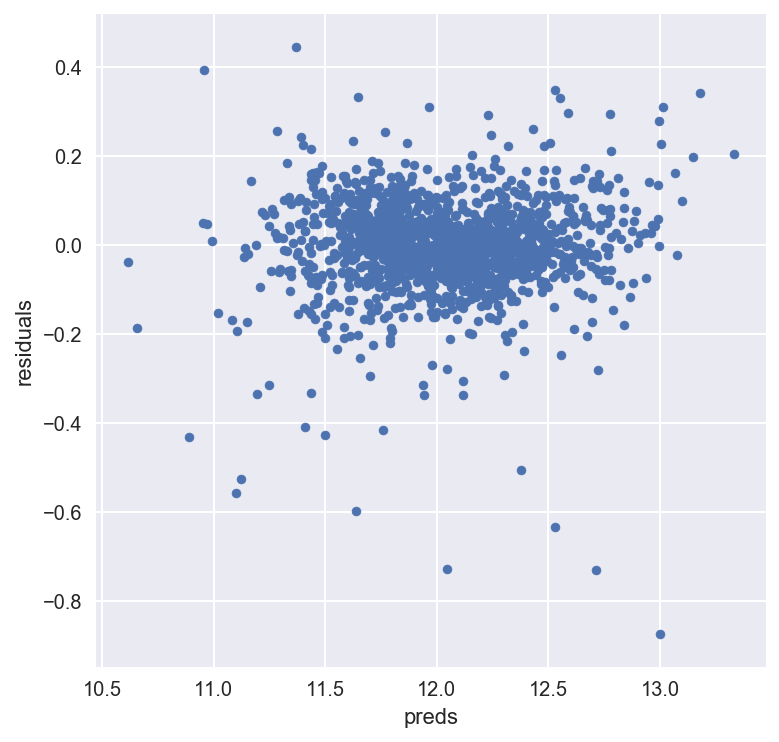

In [47]:
#查看预测值和实际值残差
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({'preds': model_lasso.predict(x_train), 'true': y})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x="preds", y="residuals", kind="scatter")

In [48]:
import sys
sys.path.append('/Users/zero/xgboost/python-package')
import xgboost as xgb

In [49]:
dtrain = xgb.DMatrix(x_train, label=y)
dtest = xgb.DMatrix(x_test)

params = {'max_depth': 2, 'eta': 0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

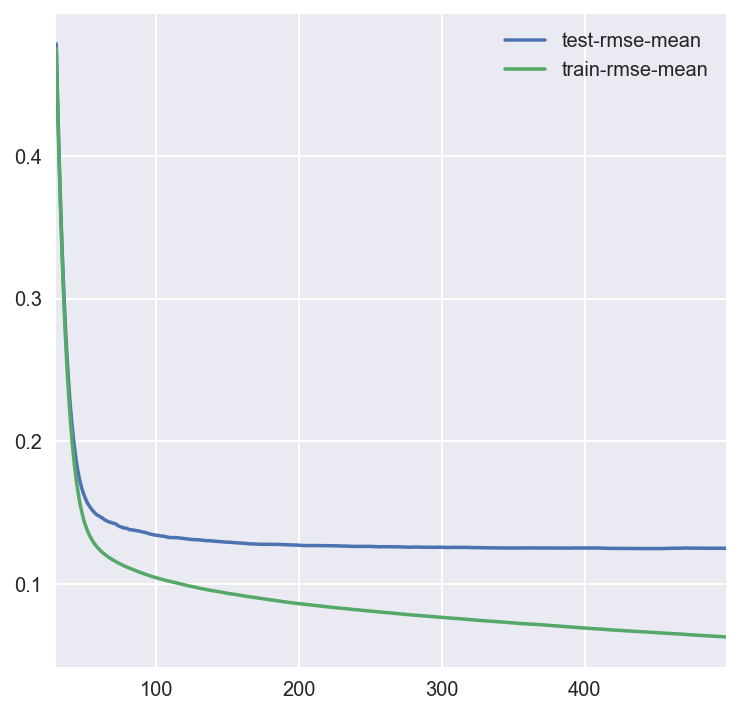

In [50]:
model.loc[30:, ["test-rmse-mean", "train-rmse-mean"]].plot()

In [51]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(x_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [52]:
xgb_preds = np.expm1(model_xgb.predict(x_test))
lasso_preds = np.expm1(model_lasso.predict(x_test))

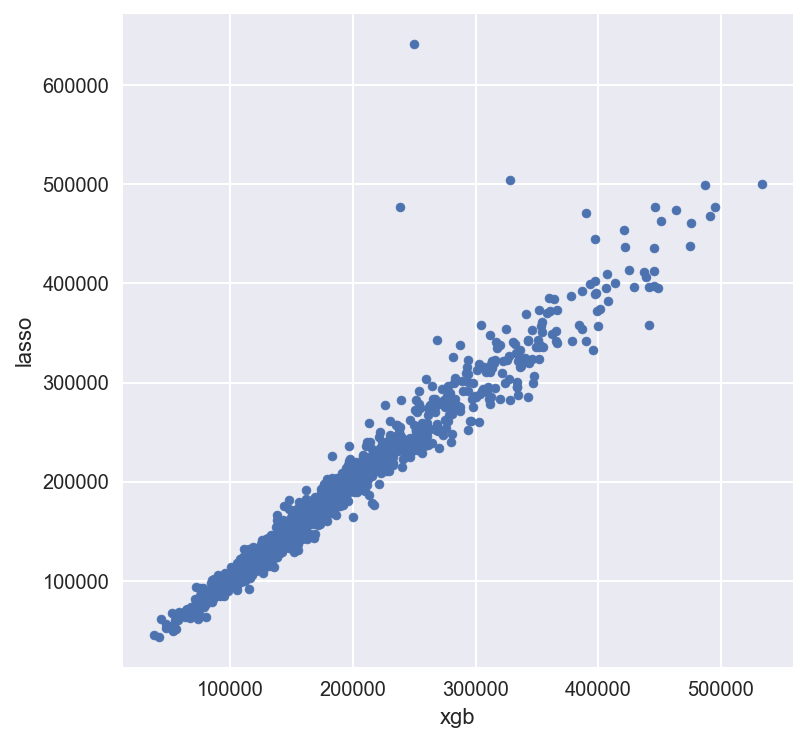

In [53]:
predictions = pd.DataFrame({'xgb': xgb_preds, 'lasso': lasso_preds})
predictions.plot(x='xgb', y='lasso', kind='scatter')

In [54]:
preds = 0.7 * lasso_preds + 0.3 * xgb_preds

In [55]:
solution = pd.DataFrame({'id': test.Id, 'SalePrice': preds})
solution.to_csv('ridge_sol.csv', index=False)

In [56]:
#test
# prices['log(price+1)']
# all_data.dtypes
# train.isnull().sum()
# pd.get_dummies(all_data)
# train.shape
# cv_ridge
# all_data.shape
# test
sys.path

['',
 '/Users/zero/anaconda2/lib/python2.7/site-packages/pip-9.0.1-py2.7.egg',
 '/Users/zero/anaconda2/lib/python2.7/site-packages/six-1.10.0-py2.7.egg',
 '/Users/zero/anaconda2/lib/python2.7/site-packages/distribute-0.6.28-py2.7.egg',
 '/Users/zero/anaconda2/lib/python2.7/site-packages/MySQL_python-1.2.3-py2.7-macosx-10.7-x86_64.egg',
 '/Users/zero/anaconda2/lib/python27.zip',
 '/Users/zero/anaconda2/lib/python2.7',
 '/Users/zero/anaconda2/lib/python2.7/plat-darwin',
 '/Users/zero/anaconda2/lib/python2.7/plat-mac',
 '/Users/zero/anaconda2/lib/python2.7/plat-mac/lib-scriptpackages',
 '/Users/zero/anaconda2/lib/python2.7/lib-tk',
 '/Users/zero/anaconda2/lib/python2.7/lib-old',
 '/Users/zero/anaconda2/lib/python2.7/lib-dynload',
 '/Users/zero/anaconda2/lib/python2.7/site-packages/Sphinx-1.5.6-py2.7.egg',
 '/Users/zero/anaconda2/lib/python2.7/site-packages',
 '/Users/zero/anaconda2/lib/python2.7/site-packages/aeosa',
 '/Users/zero/anaconda2/lib/python2.7/site-packages/IPython/extensions',

In [59]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [61]:
x_train = StandardScaler().fit_transform(x_train)
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y, random_state=3)
x_tr.shape

(1095, 288)

In [62]:
model = Sequential()
model.add(Dense(1, input_dim=x_train.shape[1], W_regularizer=l1(0.001)))
model.compile(loss='mse', optimizer='adam')

/Users/zero/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., input_dim=288)`
  


In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [66]:
hist = model.fit(x_tr, y_tr, validation_data=(x_val, y_val))

Train on 1095 samples, validate on 365 samples
Epoch 1/10
1095/1095 [==============================] - 0s - loss: 132.1345 - val_loss: 163.0963
Epoch 2/10
1095/1095 [==============================] - 0s - loss: 130.9642 - val_loss: 164.9041
Epoch 3/10
1095/1095 [==============================] - 0s - loss: 129.7769 - val_loss: 166.9086
Epoch 4/10
1095/1095 [==============================] - 0s - loss: 128.6262 - val_loss: 169.1018
Epoch 5/10
1095/1095 [==============================] - 0s - loss: 127.4148 - val_loss: 171.2711
Epoch 6/10
1095/1095 [==============================] - 0s - loss: 126.2777 - val_loss: 173.5920
Epoch 7/10
1095/1095 [==============================] - 0s - loss: 125.1810 - val_loss: 175.9563
Epoch 8/10
1095/1095 [==============================] - 0s - loss: 124.0658 - val_loss: 178.4331
Epoch 9/10
1095/1095 [==============================] - 0s - loss: 122.9715 - val_loss: 180.8643
Epoch 10/10
1095/1095 [==============================] - 0s - loss: 121.8480 - v

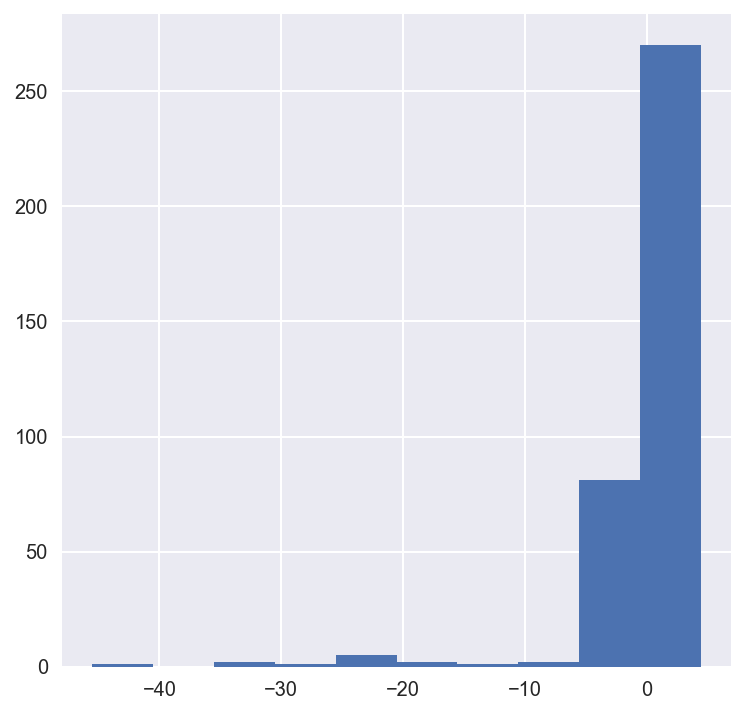

In [68]:
pd.Series(model.predict(x_val)[:, 0]).hist()